Single-Layer Effects of OD Demand
==============

Argues the following claim: the organized, partially-optimized demand structure of transportation networks (given by OD data), rather than edge weights, tend to dominate single-layer global behavior, such as travel times and congestion.

- **Methods:**
    - Computation of congested edge weights using ITA + BPR
- **Figs:**   
    - Shortest path distributions -- plots and summary stats
    - Demand/supply ratio, sensitivity to congestion

In [1]:
% matplotlib inline

# homebrewed modules
from metro import multiplex as mx
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data
from metro import ita

# Other modules
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import warnings 
import itertools
import math


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
warnings.filterwarnings('ignore') # don't display warnings when executing commands
sns.set_style("white") # nicer plots
pylab.rcParams['savefig.dpi'] = 100 # change to 300 for final publication figs

In [3]:
m = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

for layer in ['metro', 'metro--streets']:
    m.remove_layer(layer)

In [4]:
m.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

m.summary()

OD: loaded

layer           	nodes 	edges
----------------------------------------
streets          	10728 	21508
taz--streets     	0 	8486
taz              	4243 	0


In [5]:
# Certain analyses in this worksheet are very processor intensive. 
# You have the option of only running them on a subset of the nodes in the graph. 
# To do this, set a value for `n_nodes` below. 
# To run full computations, choose `n_nodes = None`.

n_nodes = None

# Weighted and Unweighted Shortest Paths

In [6]:
weights = {'congested_time_m_100' : 'congested', 
           'free_flow_time_m' : 'free flow', 
           'uniform_time_m' : 'constant'}

In [7]:
d = {w : m.path_lengths(n_nodes, w, mode = 'array') for w in weights}
d_uniform = pd.DataFrame(d)

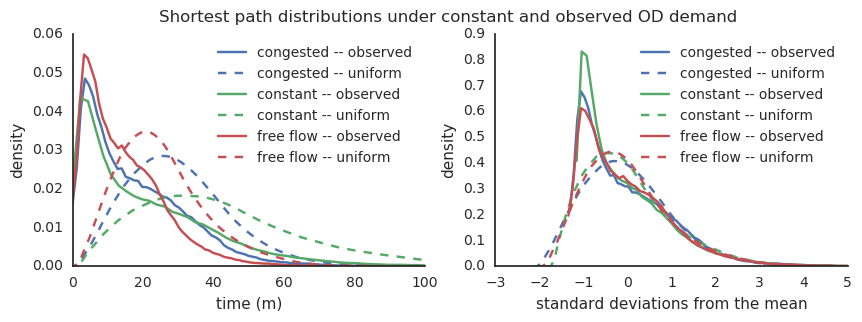

In [8]:
current_palette = sns.color_palette()

fig = plt.figure(figsize = (10, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

means = {}

i = 0
for w in weights:
    lab = weights[w]
    
    
    funs = {lab : lambda e: e[w]}
    df = m.route_summary(n_nodes = n_nodes, cost = w, layer = 'streets', funs = funs)
    
    means.update({lab : np.average(df[lab], weights=df.flow)}) 
    
    viz.weighted_hist(ax = ax1, 
                      measure = df[lab], 
                      weights = df.flow, 
                      label = lab + ' -- observed',  
                      standardized = False,
                      color = current_palette[i])
    
    viz.weighted_hist(ax = ax2, 
                      measure = df[lab], 
                      weights = df.flow, 
                      label = lab + ' -- observed',  
                      standardized = True,
                      color = current_palette[i])
    
    sns.kdeplot(d_uniform[w], 
                         label = lab + ' -- uniform', 
                         ls = '--',
                         ax = ax1,
                         color = current_palette[i])
    
    sns.kdeplot(analysis.standardize(d_uniform[w]), 
                         label = lab + ' -- uniform', 
                         ls = '--',
                         ax = ax2,
                         color = current_palette[i])
    i += 1

ax1.set(xlabel = 'time (m)', ylabel = 'density', xlim = (0,100))
ax2.set(xlabel = 'standard deviations from the mean', ylabel = 'density', xlim = (-3, 5))
plt.legend()
fig.suptitle('Shortest path distributions under constant and observed OD demand')
sns.despine()
plt.savefig('4_figs/single_layer_paths.png')

In [9]:
means

{'congested': 18.254468496234612,
 'constant': 22.087295738836527,
 'free flow': 15.03270775278369}

In [10]:
print '__SUMMARY TABLE__'
print '{0: <30}'.format('UNIFORM DEMAND') + 'MEAN'
for weight in weights:
    print '{0: <30}'.format(' ' + weight) + str(round(d_uniform[weight].mean(), 1))

print 'OD DEMAND'
for w in weights:
    print '{0: <30}'.format(' ' + weights[w]) + str(round(means[weights[w]]))


__SUMMARY TABLE__
UNIFORM DEMAND                MEAN
 congested_time_m_100         29.8
 uniform_time_m               42.3
 free_flow_time_m             25.2
OD DEMAND
 congested                    18.0
 constant                     22.0
 free flow                    15.0


# Weighted and unweighted distance between nodes

### Weighted

In [11]:
funs = {'distance' : lambda e: e['dist_km']}
df = m.route_summary(n_nodes = n_nodes, 
                     cost = 'dist_km', 
                     layer = 'streets', funs = funs)
np.average(df.distance, weights = df.flow)

11.622975149512241

### Uniform

In [12]:
dists = m.path_lengths(n_nodes = None, weight = 'dist_km', mode = 'array')
dists = dists[~np.isinf(dists)]
np.average(dists)

22.280831393848725

# Computing sensitivity to congestion

In [19]:
from scipy import stats
import statsmodels.api as sm

df = pd.read_csv('3_throughput/route_info_100.csv')
dg = df[df.gamma > 0]
dg = dg[dg.dist_km <= 40]

mean_gamma = np.average(dg.gamma, weights = dg.flow)
4 * mean_gamma

0.21451837083162778

In [17]:
mod_wls = sm.WLS(dg.congested_time_m, 
                 np.c_[dg.dist_km,np.ones(len(dg))], 
                 weights=dg.flow)
res_wls = mod_wls.fit()
print res_wls.summary()

                            WLS Regression Results                            
Dep. Variable:       congested_time_m   R-squared:                       0.876
Model:                            WLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 3.026e+07
Date:                Mon, 25 Jan 2016   Prob (F-statistic):               0.00
Time:                        12:18:01   Log-Likelihood:            -1.5939e+07
No. Observations:             4298618   AIC:                         3.188e+07
Df Residuals:                 4298616   BIC:                         3.188e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.3791      0.000   5500.891      0.0

In [20]:
coef = res_wls.params.x1
const = res_wls.params.const

v_f = m.mean_edge_attr_per(layers = ['streets'], attr = 'free_flow_time_m')
alpha = np.log(coef * v_f) / np.log(1 + 4 * mean_gamma) # *4 beecause we only assigned 1/4 of flow. 
v_f

0.96484501762121544

In [15]:
def wavg_constructor(col, weights):    
    def wavg(group):
        d = group[col]
        w = group[weights]
        return (d * w).sum() / w.sum()
    return wavg

dg['bins'] = pd.cut(dg.dist_km, bins = np.arange(40))

dists = dg.groupby('bins').apply(wavg_constructor('dist_km', 'flow'))
times = dg.groupby('bins').apply(wavg_constructor('congested_time_m', 'flow'))

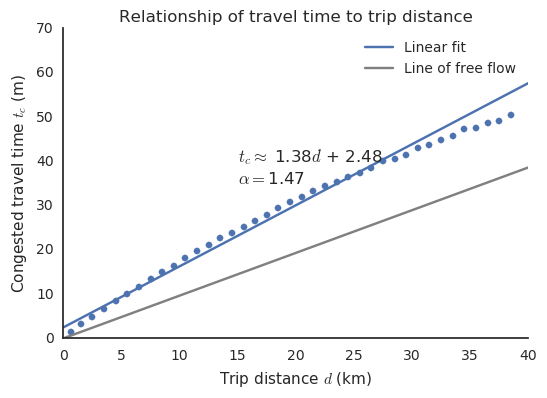

In [16]:

fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
ax.plot([0, 40], [const, 40*coef + const], color = sns.color_palette()[0], label = 'Linear fit')
ax.plot([0,40], [0, v_f * 40], color = 'grey', label = 'Line of free flow')

ax.scatter(dists, times, color = sns.color_palette()[0])
ax.set(xlim = (0, 40), 
       ylim = (0, None), 
       xlabel = r'Trip distance $d$ (km)', 
       ylabel = r'Congested travel time $t_c$ (m)',
       title = 'Relationship of travel time to trip distance') 
       
ax.text(15, 40, r'$t_c \approx$ ' + str(round(coef,2)) + r'$d$ + ' + str(round(const,2))) 
ax.text(15, 35, r'$\alpha = $' + str(round(alpha,2)))
ax.legend()
sns.despine()
plt.savefig('4_figs/time_v_distance.png')

Compared to [Serdar's paper](http://humnetlab.mit.edu/wordpress/wp-content/uploads/2010/10/understanding-congested-travel.pdf), this suggests that the city has a congestion profile most comparable to Porto or Boston. I'd say this makes sense: those are the 'most convex' cities of the ones Serdar studied, in the sense that their traffic flows are less dominated by a small number of key bridges. Compare, for example, the Bay Area, which is highly nonconvex and has high $\alpha$.  